### tracking with 10 sample delay

In [2]:
import algo_func
import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sg
import matplotlib
import scipy as sp
import importlib
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

In [34]:
import seaborn as sns

In [3]:
data = pd.read_csv('elec_data.csv',index_col = 0)
scaler = StandardScaler()
ot = np.expand_dims(data['OT'].array,axis =1)
ot_ = scaler.fit_transform(ot)

In [4]:
fil_order = 7
delay = 10
train_2,val_2,test_2 = ot_[0:10_000],ot_[10_000:11_000],ot_[11_000:]

ip_train_2 = train_2
op_train_2 = train_2[fil_order+10:]

ip_val_2 = val_2
op_val_2 = val_2[fil_order+10:]

ip_test_2 = test_2
op_test_2 = test_2[fil_order+10:]

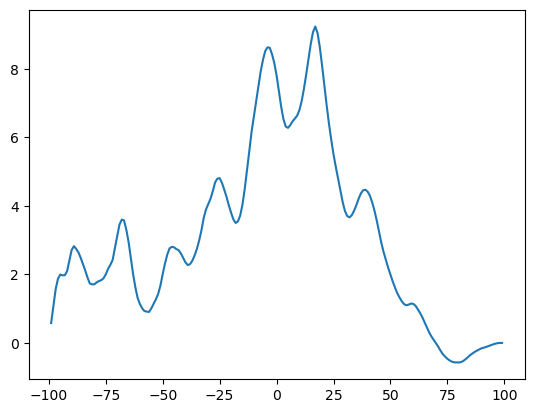

In [7]:
gg_1 = ip_train_2[:100,0]
gg_2 = op_train_2[:100,0]

ot_auto = sg.correlate(gg_1,gg_2)
ot_auto_y = sg.correlation_lags(len(gg_1),len(gg_2))
plt.plot(ot_auto_y,ot_auto)

In [8]:
gg = np.argmax(ot_auto)
ot_auto_y[gg]

17

In [6]:
importlib.reload(algo_func)

<module 'algo_func' from '/Users/skapoor/Desktop/academics/academics_2/mlts/project_2/algo_func.py'>

In [15]:
step_size = np.concatenate((np.linspace(0.01,0.001,10),np.linspace(0.001,0.0001,10)))

mse_train_step = []
mse_val_step = []

for step in step_size:
    
    y,e,w = algo_func.lms_mse(ip_train_2,op_train_2,fil_order,step)
    mse_train_step.append(algo_func.mse(ip_train_2,op_train_2,w[-1],delay)[0])
    mse_val_step.append(algo_func.mse(ip_val_2,op_val_2,w[-1],delay)[0])

In [16]:
step_size[np.argmin(mse_train_step)]

0.004

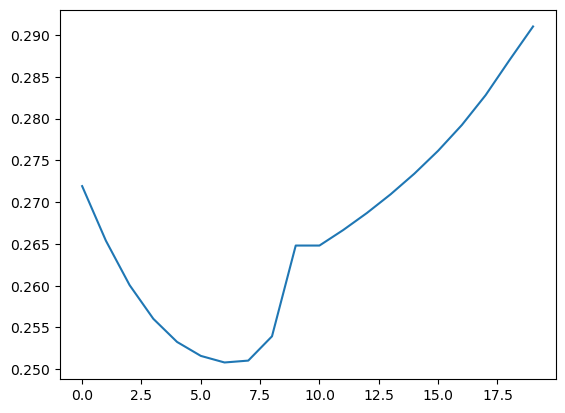

In [17]:
plt.plot(mse_train_step)

In [27]:
step_size = np.linspace(0.0031,0.004,10)

mse_train_step = []
mse_val_step = []

for step in step_size:
    
    y,e,w = algo_func.lms_mse(ip_train_2,op_train_2,fil_order,step)
    mse_train_step.append(algo_func.mse(ip_train_2,op_train_2,w[-1],delay)[0])
    mse_val_step.append(algo_func.mse(ip_val_2,op_val_2,w[-1],delay)[0])

100%|█████████████████████████████████| 9983/9983 [00:00<00:00, 172403.20it/s]


In [28]:
mse_train_step

[0.2509379321910396,
 0.2508641434680543,
 0.25080904971639884,
 0.250770611022,
 0.2507470742576365,
 0.25073694630676957,
 0.25073896874998575,
 0.25075209409388005,
 0.2507754635758331,
 0.2508083865434102]

### best step size for lms with 10 delay 0.0036

0.25073694630676957
0.19509706412861194
0.26504455939871013


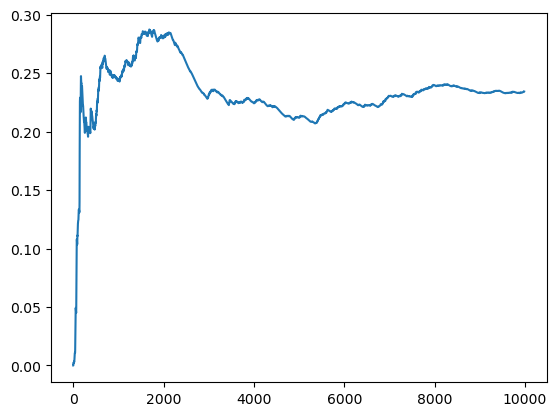

In [18]:
step_size_best = 0.0036

y,e,w = algo_func.lms_mse(ip_train_2,op_train_2,fil_order,step_size_best)
print(algo_func.mse(ip_train_2,op_train_2,w[-1],delay = 10)[0])
print(algo_func.mse(ip_val_2,op_val_2,w[-1],delay = 10)[0])
print(algo_func.mse(ip_test_2,op_test_2,w[-1],delay = 10)[0])
plt.plot(algo_func.learn_curve(e))

In [19]:
np.argmin(algo_func.learn_curve(e)[2000:])

3363

In [20]:
wts_it = 2000 + np.argmin(algo_func.learn_curve(e)[2_000:])

In [21]:
print(algo_func.mse(ip_train_2,op_train_2,w[-1],delay = 10)[0])
print(algo_func.mse(ip_val_2,op_val_2,w[-1],delay = 10)[0])
print(algo_func.mse(ip_test_2,op_test_2,w[-1],delay = 10)[0])

0.25073694630676957
0.19509706412861194
0.26504455939871013


In [23]:
def pred(ip,w,delay):
    
    ip = ip[:,0]
    len_w = len(w)
    y = sg.lfilter(w,1,ip)
    y = y[len_w:-delay+1]
    
    return y

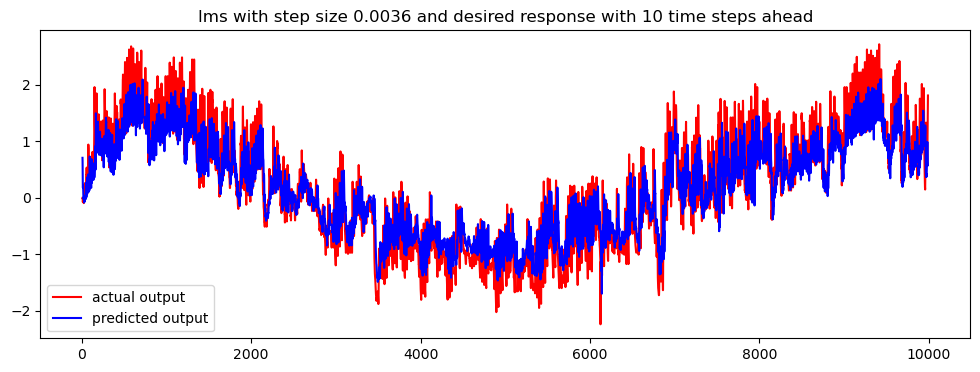

In [24]:
# for train
ser = np.arange(fil_order+1,len(ip_train_2)-delay+1)
fig = plt.figure(figsize = (12,4))
plt.plot(ser,op_train_2,'-r',label = 'actual output')
plt.plot(ser,pred(ip_train_2,w[-1],delay),'-b',label = 'predicted output')
plt.title('lms with step size 0.0036 and desired response with 10 time steps ahead')
plt.legend()

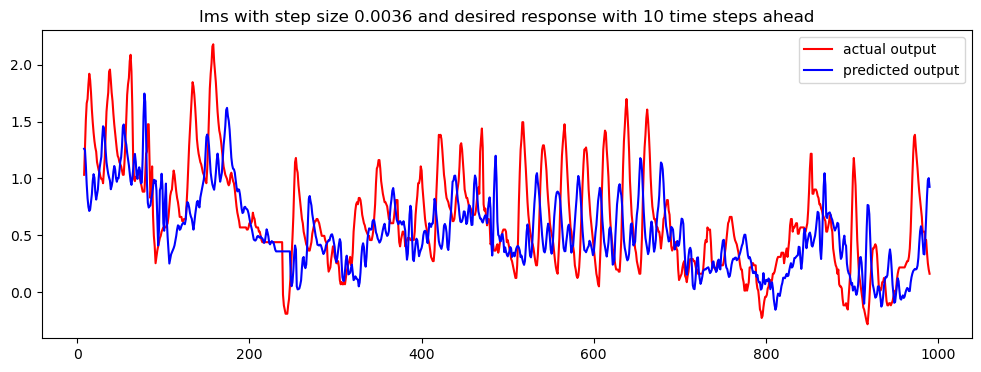

In [26]:
# for train
ser = np.arange(fil_order+1,len(ip_val_2)-delay+1)
fig = plt.figure(figsize = (12,4))
plt.plot(ser,op_val_2,'-r',label = 'actual output')
plt.plot(ser,pred(ip_val_2,w[-1],delay),'-b',label = 'predicted output')
plt.title('lms with step size 0.0036 and desired response with 10 time steps ahead')
plt.legend()

In [42]:
op_val_2.shape

(983, 1)

In [43]:
pred(ip_val_2,w[-1],delay).shape

(983,)

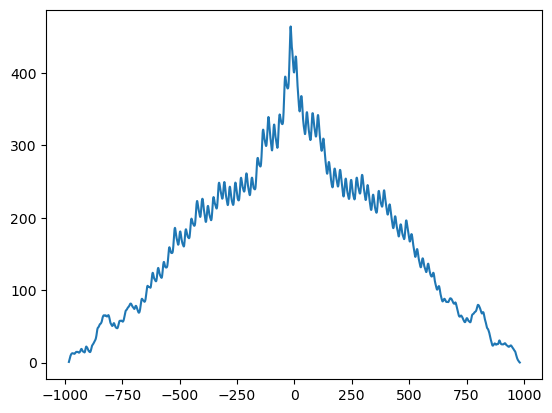

In [45]:
ot_auto = sg.correlate(op_val_2[:,0],pred(ip_val_2,w[-1],delay))
ot_auto_y = sg.correlation_lags(len(op_val_2[:,0]),len(pred(ip_val_2,w[-1],delay)))
plt.plot(ot_auto_y,ot_auto)

In [49]:
gg = np.argmax(ot_auto)
ot_auto_y[gg]

-16

In [52]:
def mse(ip,op,w,delay):
    
    w_len = len(w)
    op_len = len(op)
    e = np.zeros((op_len,1))
    y = np.zeros((op_len,1))
    for i in tqdm(range(op_len-delay+1)):
        
        ip_1 = ip[i:i+w_len]
        ip_1 = ip_1[::-1]
        y_pred = ip_1.T@w
        
        e[i] = y_pred.item() - op[i].item()
        y[i] = y_pred
    
    mse = np.average(e**2)
    return mse,y

100%|███████████████████████████████████| 974/974 [00:00<00:00, 199193.14it/s]


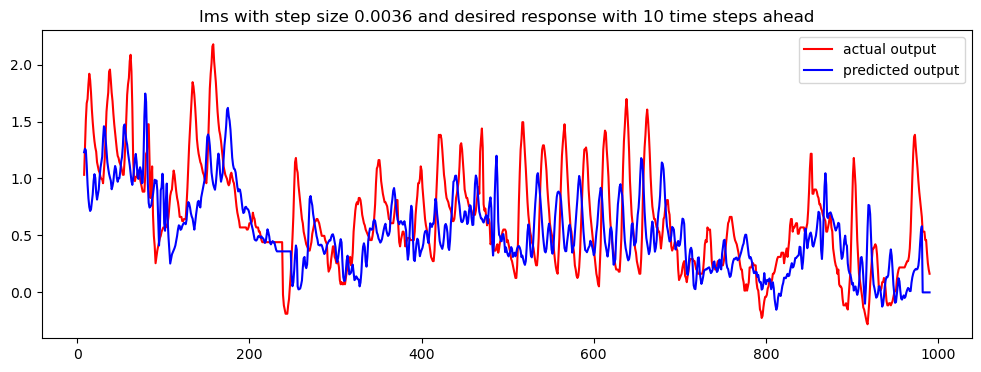

In [60]:
# for train
ser = np.arange(fil_order+1,len(ip_val_2)-delay+1)
fig = plt.figure(figsize = (12,4))
plt.plot(ser,op_val_2,'-r',label = 'actual output')
plt.plot(ser,mse(ip_val_2,op_val_2,w[-1],delay)[1],'-b',label = 'predicted output')
plt.title('lms with step size 0.0036 and desired response with 10 time steps ahead')
plt.legend()

**We cant use linear methods to model the prediction of 10 time step ahead , this is because,
in linear modelling in this time series , one time step ahead prediction is highly dependent on the past values.**

### Prediciting samples ahead 50

In [29]:
print(algo_func.mse_lms_ahead(ip_train_2,op_train_2,w[-1],41))

100%|█████████████████████████████████████| 9942/9942 [00:04<00:00, 2249.65it/s]

3.207395288025271


### Training MCC with lms for 10 delay prediction

In [44]:
kern_size_arr = np.concatenate((np.linspace(2,1,5),np.linspace(0.9,0.5,5)))
step_size_arr = np.concatenate((np.linspace(0.02,0.01,2),np.linspace(0.009,0.001,10)))
k1,k2 = len(kern_size_arr),len(step_size_arr)

print(k1,k2)

mse_train_step = np.zeros((k1,k2))
mse_val_step = np.zeros((k1,k2))

fil_order = 7


for i in tqdm(range(k1)):
    
    kern_size = kern_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,_,w = algo_func.lms_mcc(ip_train_2,op_train_2,fil_order,step_size,kern_size)
        mse_train_step[i][j]=algo_func.mse(ip_train_2,op_train_2,w[-1],delay)[0]
        mse_val_step[i][j] = algo_func.mse(ip_val_2,op_val_2,w[-1],delay)[0]

10 12


100%|███████████████████████████████████████████| 10/10 [00:05<00:00,  1.87it/s]


<Axes: >

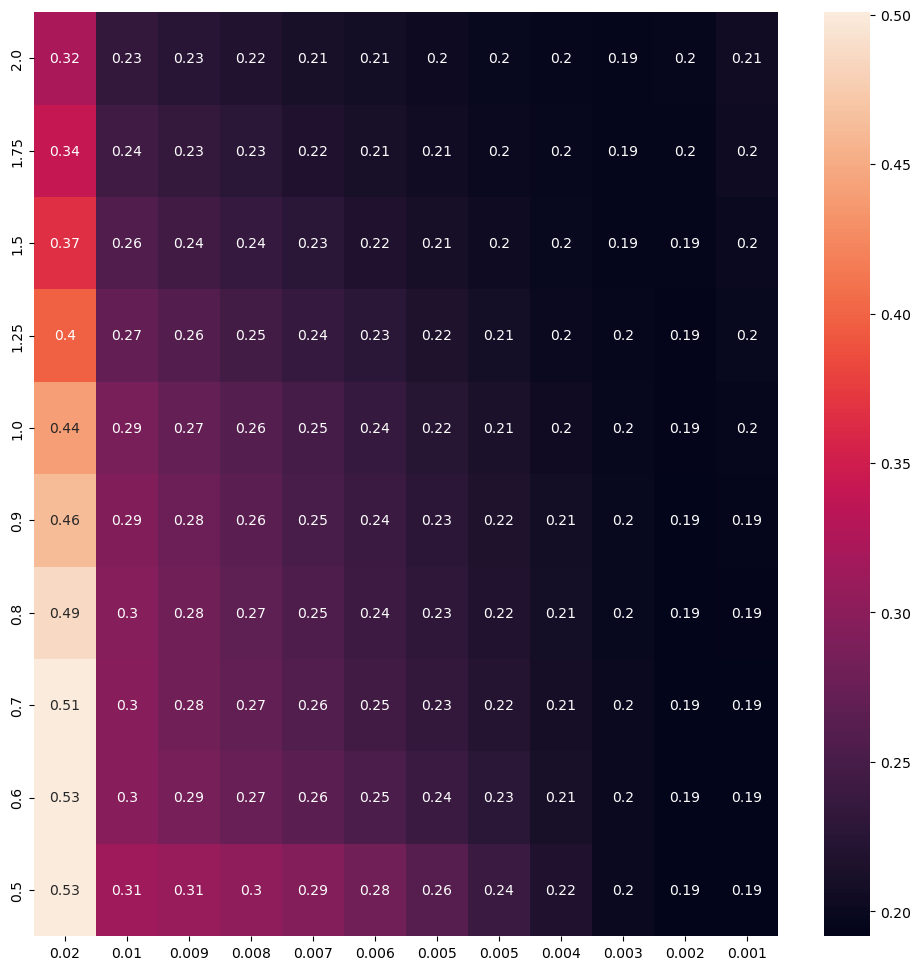

In [45]:
fig = plt.figure(figsize = (12,12))
sns.heatmap(np.round(mse_val_step,5),xticklabels= np.round(step_size_arr,3),yticklabels=np.round(kern_size_arr,3),robust = True,annot = True)

In [47]:
gg = np.argmin(mse_val_step)
kern_id,step_id = np.unravel_index(gg,mse_val_step.shape)
print(kern_size_arr[kern_id])
print(step_size_arr[step_id])
print(mse_val_step[kern_id][step_id])

0.5
0.0018888888888888879
0.19019977692050843


In [49]:
kern_size_arr = [0.5]
step_size_arr = [0.002]
k1,k2 = len(kern_size_arr),len(step_size_arr)

print(k1,k2)

mse_train_step = np.zeros((k1,k2))
mse_val_step = np.zeros((k1,k2))

fil_order = 7


for i in tqdm(range(k1)):
    
    kern_size = kern_size_arr[i]
    
    for j in range(k2):
        
        step_size = step_size_arr[j]
        y,_,w = algo_func.lms_mcc(ip_train_2,op_train_2,fil_order,step_size,kern_size)
        mse_train_step[i][j]=algo_func.mse(ip_train_2,op_train_2,w[-1],delay)[0]
        mse_val_step[i][j] = algo_func.mse(ip_val_2,op_val_2,w[-1],delay)[0]

1 1


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 13.14it/s]


### For lms we got mcc kernel size as 0.5, and step size as 0.002 with mse 0.19

In [50]:
print('for predicting 50 samples ahead')
print(algo_func.mse_lms_ahead(ip_train_2,op_train_2,w[-1],41))

for predicting 50 samples ahead


100%|█████████████████████████████████████| 9942/9942 [00:04<00:00, 2234.70it/s]

28534.622567198978


100%|█████████████████████████████████████| 974/974 [00:00<00:00, 203509.62it/s]


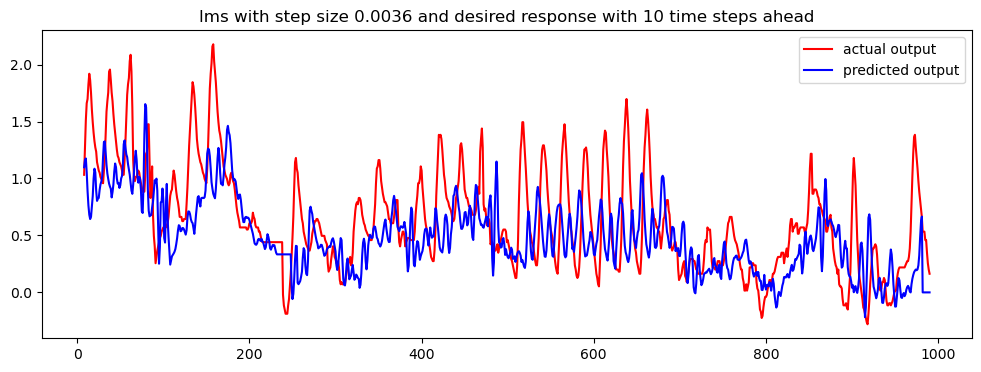

In [53]:
ser = np.arange(fil_order+1,len(ip_val_2)-delay+1)
fig = plt.figure(figsize = (12,4))
plt.plot(ser,op_val_2,'-r',label = 'actual output')
plt.plot(ser,mse(ip_val_2,op_val_2,w[-1],delay)[1],'-b',label = 'predicted output')
plt.title('lms with step size 0.0036 and desired response with 10 time steps ahead')
plt.legend()

In [54]:
### For both the lms models it performs bad as it shows high correlation in predicting from the past values

In [55]:
### Moreover we can see that their is delay in the ouput which shows 
###that its trying to predict the next best time step